In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms import VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [2]:
random_state = 23

In [3]:
path = '../datasets/'
df = pd.read_csv(path + 'insurance.csv')

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
categorical_columns = ['sex', 'children', 'smoker', 'region']
df_encode = pd.get_dummies(
    data=df, prefix='OHE',
    columns=categorical_columns,
    drop_first=True,
    dtype='int8')

In [6]:
df_encode['charges'] = np.log(df_encode['charges'])

In [7]:
X = df_encode.drop('charges', axis=1)  # Independent variable
y = df_encode['charges']  # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [9]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error

J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test, y_test)
print('The Mean Square Error(MSE) or J(theta) is: ', J_mse_sk)
print('R square obtain for scikit learn library is :', R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  0.18729622322981904
R square obtain for scikit learn library is : 0.7795687545055316


Quantum approach

In [31]:
n_features = X_train.shape[1]

In [92]:
from qiskit.circuit.library import ZFeatureMap

# # construct simple feature map
# param_x = Parameter("x")
# feature_map = QuantumCircuit(n_features, name="fm")
# feature_map.ry(param_x, 0)
#
# # construct simple ansatz
# param_y = Parameter("y")
# ansatz = QuantumCircuit(n_features, name="vf")
# ansatz.ry(param_y, 0)

feature_map = ZZFeatureMap(n_features)
ansatz = RealAmplitudes(n_features, reps=1)

# construct a circuit
qc = QuantumCircuit(n_features)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# construct QNN
regression_estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

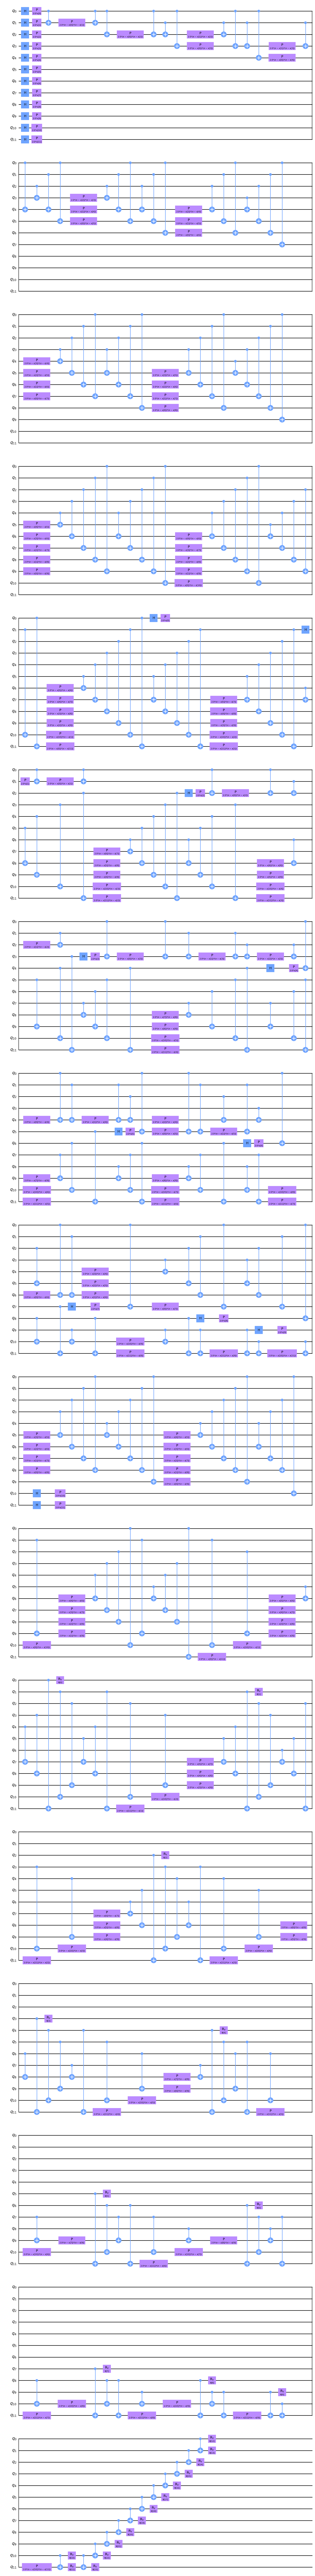

In [93]:
qc.decompose().draw(output="mpl")

In [94]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5)
)

In [ ]:
regressor.fit(X_train.iloc[:, :].to_numpy(), y_train.to_numpy())

In [84]:
regressor.score(X_test.iloc[:, :].to_numpy() * 10, y_test.to_numpy())

-78.27948547535408

In [91]:
(((regressor.predict(X_test) )[0] - y_test) ** 2).sum() / len(X_test)

82.96228713024215

In [83]:
y_test

918      9.475924
755      8.523428
207      9.951520
520     10.152555
695      8.071295
          ...    
1302     8.073648
1191     9.527009
1085     9.853418
663      7.035620
977      7.973468
Name: charges, Length: 402, dtype: float64